Divisive suppression explains high-precision firing and contrast adaptation in retinal ganglion cells <br>
url = {https://dx.doi.org/10.7554/elife.19460}

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
def NGD_TK_AS(T, epsilon, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):50]*dt

In [18]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Data

In [19]:
dt = 0.01
cn = 50

file_list = ['D:\\GoogleDrive\\retina\\Exps\\2021\\1130\\SplitData\\diode_WhiteNoise_mean=10_C=0.1_01-Dec-2021_0',
             'D:\\GoogleDrive\\retina\\Exps\\2021\\1130\\SplitData\\diode_WhiteNoise_mean=10_C=0.2_01-Dec-2021_0',
             'D:\\GoogleDrive\\retina\\Exps\\2021\\1130\\SplitData\\diode_WhiteNoise_mean=10_C=0.3_01-Dec-2021_0']
contrast_list = [10, 20, 30]
x_list = []
T_list = []
rstate_list = []

sampling_rate = 20000
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
   
    TicTocer = annots['a_data'][1]
    startPoint = np.where(TicTocer>38000)[0][0]
    endPoint = np.where(TicTocer>38000)[0][-1]
    x = annots['a_data'][0, startPoint:endPoint+1]
    x = np.convolve(x, np.ones(int(sampling_rate*dt*0.5))/int(sampling_rate*dt*0.5), 'same')
    x = x[int(sampling_rate*dt*0.5)::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x-np.mean(x))/np.std(x)
    tEdge = np.arange(len(x)+1)*dt

    Spike = annots['Spikes'][cn-1]
    Spike = Spike[np.where(Spike>startPoint/sampling_rate)[0][0]:np.where(Spike<endPoint/sampling_rate)[0][-1]]-startPoint/sampling_rate
    rstate, _ = np.histogram(Spike, tEdge)
    
    rstate_list.append( rstate.copy() )
    x_list.append( x.copy() )
    T_list.append( tEdge.copy() )

In [20]:
for i in range(len(x_list)):
    print(sum(rstate_list[i]))


1888
2105
2168


(0.0, 1.0)

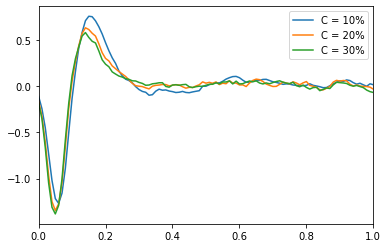

In [21]:
TKaxis = np.arange(101)*dt
TK_list = []
for i in range(len(x_list)):
    rstate = rstate_list[i]
    x = x_list[i]
    x = (x -np.mean(x))/np.std(x)
    TK = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    TK = TK[int(len(TK)/2):int(len(TK)/2-1/dt)-1:-1]
    plt.plot(TKaxis, TK, label = 'C = '+str(contrast_list[i])+'%')
    TK_list.append( TK.copy() )
plt.legend(loc = 'best')
plt.xlim(0, 1)

# Fit

(0.0, 1.0)

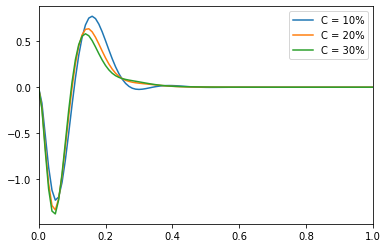

In [22]:
name_list  = ['epsilon', 'omegastar', 'deltastar', 'tau_y', 'Bmp' ]
initials   = [5        , 20         , 0.         , 0.03   , 2     ]
ibounds_min = [0        , 0          , -np.pi     , 0      , 0     ]
ibounds_max = [np.inf   , np.inf     ,  np.pi     , 0.5    , np.inf]

para_2dlist = [0]*len(x_list)
fitTK_list = [0]*len(x_list)

bounds_min = ibounds_min.copy()
bounds_max = ibounds_max.copy()
for i in range(len(x_list)):
# for i in range(len(x_list)):
    popt,_ = curve_fit(NGD_TK_AS, TKaxis , TK_list[i], p0= initials, bounds = (bounds_min,bounds_max) )
    initials = popt
    # bounds_min = popt-1E-7
    # bounds_max = popt+1E-7
    # # chose which parameters to free
    # for j in [0,1,2,3]:
    #     bounds_min[j] = ibounds_min[j]
    #     bounds_max[j] = ibounds_max[j]
    fitTK = NGD_TK_AS(TKaxis, *popt)
    plt.plot(TKaxis, fitTK, label = 'C = '+str(contrast_list[i])+'%')
    fitTK_list[i] = fitTK.copy() 
    para_2dlist[i] = popt.copy()
plt.legend(loc = 'best')
plt.xlim(0, 1)

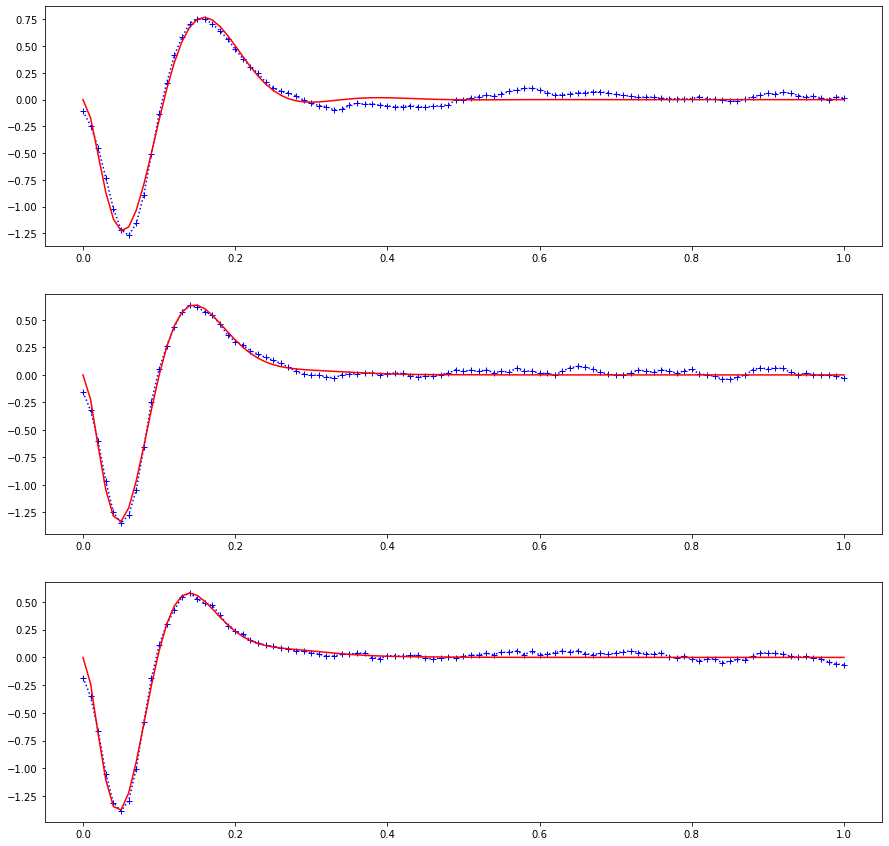

In [23]:
fig, ax = plt.subplots(len(x_list),1)
for i in range(len(x_list)):
    ax[i].plot(TKaxis, TK_list[i], 'b+:')
    ax[i].plot(TKaxis, fitTK_list[i], 'r-')
    # ax[i][1].plot(faxis, delta)
fig.set_size_inches( 15, 5*len(x_list) )

In [24]:
ASpara_DF = pd.DataFrame(para_2dlist, index = contrast_list, columns = name_list)
ASpara_DF

,epsilon,omegastar,deltastar,tau_y,Bmp
10,15.220040,27.752170,0.484381,0.044791,43898.489862
20,21.054055,32.425577,0.544009,0.048079,67526.560882
30,21.776116,36.626419,0.493223,0.051583,82082.866341


In [25]:
DEpara_DF = pd.DataFrame(np.ones((len(contrast_list), 6)), index = contrast_list, columns = ['m', 'n', 'alpha', 'beta', 'g', 'tau_y'])
DEpara_DF['m'] = ASpara_DF['Bmp']
DEpara_DF['tau_y'] = ASpara_DF['tau_y']
DEpara_DF['alpha'] = ASpara_DF['epsilon']+np.tan(ASpara_DF['deltastar'])*ASpara_DF['omegastar']
DEpara_DF['beta'] = ASpara_DF['epsilon']*2-DEpara_DF['alpha']
DEpara_DF['g'] = ASpara_DF['omegastar']**2+((DEpara_DF['alpha']-DEpara_DF['beta'])**2)/4

In [26]:
DEpara_DF

,m,n,alpha,beta,g,tau_y
10,43898.489862,1.0,29.822996,0.617084,983.429290,0.044791
20,67526.560882,1.0,40.668034,1.440076,1436.126203,0.048079
30,82082.866341,1.0,41.464112,2.088119,1729.111759,0.051583


In [27]:
DEpara_DF.loc[30].values

array([8.20828663e+04, 1.00000000e+00, 4.14641118e+01, 2.08811942e+00,
       1.72911176e+03, 5.15832326e-02])

# k_E and k_S

In [39]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    n = np.sqrt(g)
    g = np.sqrt(g)
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    # print(np.sum(y))
    return y[:len(T):50], z[:len(T):50]

In [40]:
NGD_TK(TKaxis, *DEpara_DF.loc[30].values)

94.39849072477558


In [34]:
y_TK, w_TK = NGD_TK(TKaxis, *DEpara_DF.loc[30].values)
# plt.plot(TKaxis, y_TK)
# plt.plot(TKaxis, w_TK)

0.09439565140369922


TypeError: cannot unpack non-iterable NoneType object